In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import pickle
import logging
from tqdm import tqdm

import numpy as np
from scipy import interpolate
from astropy.io import fits
import jax.numpy as jnp

WDIR = os.environ['DM21CM_DIR']
sys.path.append(WDIR)
import dm21cm.physics as phys
from dm21cm.utils import load_h5_dict
from dm21cm.dm_params import DMParams
from dm21cm.evolve import get_z_edges
from dm21cm.interpolators_jax import BatchInterpolator

sys.path.append(os.environ['DH_DIR'])
import darkhistory
import darkhistory.physics as dh_phys
from darkhistory.spec.spectrum import Spectrum
from darkhistory.main import evolve as dh_evolve
from darkhistory.config import load_data as dh_load_data
print(darkhistory.__version__)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file(f"{WDIR}/matplotlibrc")

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


1.0.0-dm21cm.0


In [2]:
tf_name = 'zf01'
abscs = load_h5_dict(f"{WDIR}/data/abscissas/abscs_{tf_name}.h5")

## dm21cm_tf

In [3]:
dc_dep_tf = BatchInterpolator(f"{os.environ['DM21CM_DATA_DIR']}/tf/{tf_name}/elec_dep.h5")
dc_scat_tf = BatchInterpolator(f"{os.environ['DM21CM_DATA_DIR']}/tf/{tf_name}/elec_scat.h5")

In [4]:
# inject 1 electron
spec_N = np.zeros((500,))
i_injE = 428
spec_N[i_injE] = 1.
elecEk = dc_dep_tf.abscs['Ein']
injE = np.dot(spec_N, elecEk + phys.m_e)
print(f'total energy = {injE} eV')

total energy = 83739425895.51418 eV


In [10]:
rs = 38.71318413405634
i_rs = 8
rs = abscs['rs'][i_rs]
print(rs)
i_x = 3
xe = abscs['x'][i_x]
print(xe)
nBs = 1.0
print(nBs)

38.71318413405634
0.01
1.0


In [11]:
f_dc = dc_dep_tf(
    in_spec = spec_N,
    sum_result = False,
    rs = rs,
    nBs_s = jnp.array([nBs]),
    x_s = jnp.array([xe]),
    out_of_bounds_action = 'clip',
) / injE

f_dc = np.array(f_dc).flatten()
print(f_dc)

[2.71374026e-04 1.00901268e-05 1.56921757e-04 3.55957353e-04
 6.00383670e-05 2.01473613e-03]


In [12]:
sec_phot_N = dc_scat_tf(
    in_spec = spec_N,
    sum_result = False,
    rs = rs,
    nBs_s = jnp.array([nBs]),
    x_s = jnp.array([xe]),
    out_of_bounds_action = 'clip',
)
f_phot_dc = np.dot(sec_phot_N, abscs['photE']) / injE

In [13]:
print(np.sum(f_dc[:5]) + f_phot_dc)

[0.99999995]


## DH_run

In [9]:
tf_version = 'zf01'

dh_load_data('dep_tf', prefix=f"{os.environ['DH_DATA_DIR']}/../DHdata_v1_1_{tf_version}")
dh_load_data('ics_tf', prefix=f"{os.environ['DH_DATA_DIR']}/../DHdata_v1_1_{tf_version}");

****** Loading transfer functions... ******
Using data at /n/holyscratch01/iaifi_lab/yitians/darkhistory/DHdata_v1_1/../DHdata_v1_1_zf01
    for propagating photons...   Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy rate...  Done!
****** Loading complete! ******
****** Loading transfer functions... ******
    for inverse Compton (Thomson)...  Done!
    for inverse Compton (relativistic)...  Done!
    for inverse Compton (energy loss)...  Done!
****** Loading complete! ******


In [14]:
soln = dh_evolve(
    DM_process='swave', mDM=injE+1, sigmav=1e-25, primary='elec_delta', # sigmav shouldn't matter
    start_rs=rs, end_rs=rs/1.01,
    coarsen_factor=12, backreaction=True,
    struct_boost=lambda rs: 1.,
    init_cond=(xe, phys.chi*xe, 10*phys.kB),
    use_tqdm=False, verbose=1,
    cross_check_21cmfast=True,
)

Loading time: 0.023 s
Initialization time: 0.171 s


/n/home07/yitians/darkhistory/DarkHistory/darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


lowengelec_spec_at_rs 5.939512594328622e-07
deposited_ion 2.7078735085180553e-07
deposited_exc 2.1454341136254034e-07
deposited_heat 8.510457632972852e-08
deposited_ICS -1.4707940988656798e-10
ics_phot_spec 0.9999927335100701
positronium_phot_spec 6.102250411110153e-06
highengphot_spec_at_rs 0.9999988357604813
lowengelec_spec_at_rs 6.007311228978402e-07
deposited_ion 2.7406359264873863e-07
deposited_exc 2.1688078573417458e-07
deposited_heat 7.080990656333432e-08
deposited_ICS -1.4691988912775464e-10
ics_phot_spec 0.9999927354111011
positronium_phot_spec 6.102250411110154e-06
highengphot_spec_at_rs 2.004319883736032
Main loop time: 0.368 s


In [15]:
f_dh = np.array([soln['f']['low'][k] + soln['f']['high'][k] for k in soln['f']['low']])
f_dh = f_dh[:,0]

In [16]:
f_dh

array([2.71374045e-04, 1.00901271e-05, 1.56921772e-04, 3.55957373e-04,
       1.44768956e-04])

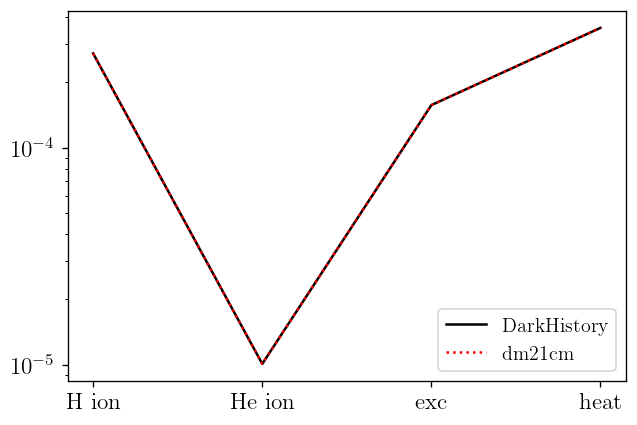

In [17]:
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL+1)

fig, ax = plt.subplots()

ax.plot(f_dh[:4], label='DarkHistory', color='k')
ax.plot(f_dc[:4], label='dm21cm', color='r', ls=':')
ax.set_xticks(np.arange(4))
ax.set_xticklabels([s.decode('utf-8') for s in dc_dep_tf.abscs['out'][:4]])
ax.set(yscale='log')
#ax.set(ylim=(1e-7,1e-4))
ax.legend();

In [18]:
f_dc[:4] / f_dh[:4]

array([0.99999993, 0.99999997, 0.99999991, 0.99999994])